## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
deg = 2 # polynomial kernel
x, c = shortestpath.genData(n, p, grid, deg=2)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=0.2, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 800/800 [00:04<00:00, 187.50it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 172.46it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Loss Function

In [15]:
from loss import SPOPlusLoss

In [16]:
# init SPO+ loss
criterion = SPOPlusLoss()

## Linear Regression 

In [17]:
import torch
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training 

In [19]:
from matplotlib import pyplot as plt

In [20]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [21]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-3)

In [22]:
# train model
num_epochs = 200
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 5, loss:8.099779
epoch 10, loss:3.599141
epoch 15, loss:1.812626
epoch 20, loss:1.224762
epoch 25, loss:0.700830
epoch 30, loss:1.182923
epoch 35, loss:0.613806
epoch 40, loss:1.177821
epoch 45, loss:1.568670
epoch 50, loss:1.215035
epoch 55, loss:0.612569
epoch 60, loss:0.723868
epoch 65, loss:1.743960
epoch 70, loss:0.237053
epoch 75, loss:0.568758
epoch 80, loss:1.003181
epoch 85, loss:0.783003
epoch 90, loss:0.299828
epoch 95, loss:0.669302
epoch 100, loss:0.722064
epoch 105, loss:1.103333
epoch 110, loss:1.444470
epoch 115, loss:0.932818
epoch 120, loss:0.898789
epoch 125, loss:1.092160
epoch 130, loss:0.636796
epoch 135, loss:1.082613
epoch 140, loss:1.402875
epoch 145, loss:0.843796
epoch 150, loss:1.920856
epoch 155, loss:0.484023
epoch 160, loss:0.904838
epoch 165, loss:0.348377
epoch 170, loss:0.991445
epoch 175, loss:0.452012
epoch 180, loss:0.654733
epoch 185, loss:0.324849
epoch 190, loss:0.397911
epoch 195, loss:0.708110
epoch 200, loss:0.857160


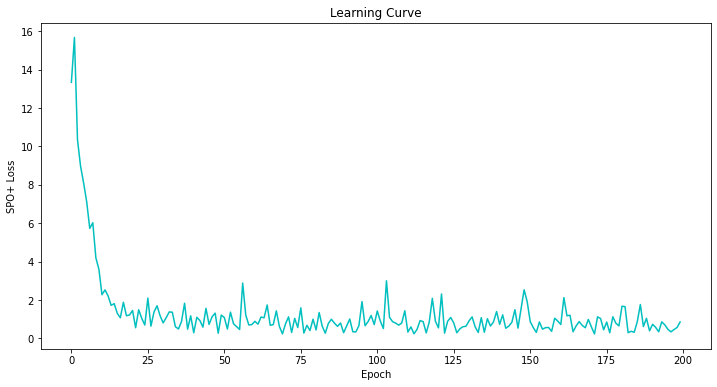

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [24]:
import numpy as np

In [25]:
# evaluate
lr.eval()
loss = 0
optsum = 0
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # accumulate loss
    loss += criterion.apply(sp_model, cp, c, w, z).sum().item()
    optsum += z.sum().item()
print('Normalized loss on test: {:.2f}%'.format(loss / optsum * 100))

Normalized loss on test: 6.16%


In [26]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 7.57, 3.98, 2.80, 7.73, 3.88, 6.49, 3.63, 2.84, 8.92, 4.40, 6.49, 4.39, 5.95, 2.84, 8.35, 2.84, 4.50, 2.26, 1.40, 6.49, 4.39, 2.26, 3.17, 5.88, 5.26, 3.63, 8.35, 8.35, 1.73, 4.79, 1.57, 5.95, 1.57, 3.98, 2.80, 4.79, 3.63, 4.79, 2.01, 2.26
    Pred cost: 0.34, 1.05, 2.55, 0.62, -1.35, 2.50, 0.07, 1.36, -0.91, -0.47, 0.71, 1.43, 0.10, -2.60, 1.64, -0.85, -1.38, 1.90, -2.45, 1.22, -0.32, 0.31, 0.48, -0.90, 0.94, -1.19, 2.00, -0.21, -0.49, -0.64, -0.38, -0.44, -0.58, -1.08, -0.58, 0.83, -1.33, -0.09, -1.57, -0.32
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, True obj: 23.98
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 23.98

Sample 1:
    True cost: 1.15, 1.89, 2.80, 1.09, 1.07, 1.30, 1.11, 1.01, 1.21, 1.93, 1.30, 1.03, 1.32, 1.01, 1.10, 1.01, 1.27, 2.41, 1.09, 1.30, 1.03, 2.41, 1.

##  Training with Regularization

In [27]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-3)

In [29]:
# train model
num_epochs = 200
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 5, loss:9.699282
epoch 10, loss:4.509700
epoch 15, loss:2.501147
epoch 20, loss:2.080661
epoch 25, loss:1.109214
epoch 30, loss:0.934796
epoch 35, loss:0.976006
epoch 40, loss:1.931531
epoch 45, loss:1.538661
epoch 50, loss:1.356359
epoch 55, loss:0.969749
epoch 60, loss:0.755533
epoch 65, loss:1.107924
epoch 70, loss:1.375113
epoch 75, loss:0.627239
epoch 80, loss:0.452022
epoch 85, loss:0.830580
epoch 90, loss:0.962121
epoch 95, loss:0.846564
epoch 100, loss:0.690283
epoch 105, loss:1.053470
epoch 110, loss:2.214549
epoch 115, loss:1.115948
epoch 120, loss:0.439979
epoch 125, loss:1.147120
epoch 130, loss:1.355719
epoch 135, loss:1.347689
epoch 140, loss:0.301157
epoch 145, loss:0.714539
epoch 150, loss:0.721945
epoch 155, loss:1.004863
epoch 160, loss:0.941234
epoch 165, loss:0.517677
epoch 170, loss:0.711236
epoch 175, loss:0.633433
epoch 180, loss:0.466218
epoch 185, loss:0.945547
epoch 190, loss:1.462567
epoch 195, loss:1.636354
epoch 200, loss:1.411901


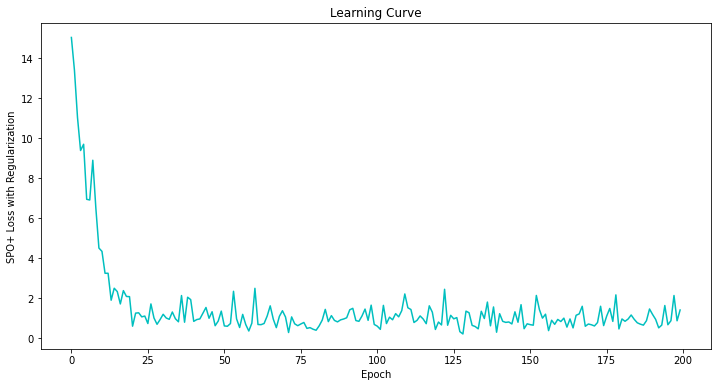

In [30]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [31]:
# evaluate
lr.eval()
loss = 0
optsum = 0
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # accumulate loss
    loss += criterion.apply(sp_model, cp, c, w, z).sum().item()
    optsum += z.sum().item()
print('Normalized loss on test: {:.2f}%'.format(loss / optsum * 100))

Normalized loss on test: 5.76%


In [32]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 7.57, 3.98, 2.80, 7.73, 3.88, 6.49, 3.63, 2.84, 8.92, 4.40, 6.49, 4.39, 5.95, 2.84, 8.35, 2.84, 4.50, 2.26, 1.40, 6.49, 4.39, 2.26, 3.17, 5.88, 5.26, 3.63, 8.35, 8.35, 1.73, 4.79, 1.57, 5.95, 1.57, 3.98, 2.80, 4.79, 3.63, 4.79, 2.01, 2.26
    Pred cost: 2.28, 0.48, 0.34, -1.08, -1.28, 1.54, -1.13, 2.84, 0.96, 1.35, -0.14, 0.41, 2.28, -2.38, 1.41, -0.44, -0.30, 1.31, -2.02, 1.38, 0.40, 1.16, -0.13, -0.79, 1.60, 0.08, 1.46, 0.77, 0.05, 0.03, -1.71, -0.52, 0.22, -0.40, -0.20, 1.26, 0.96, 0.31, -0.68, -1.57
    True sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, True obj: 23.98
    Pred sol: 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, Pred obj: 23.98

Sample 1:
    True cost: 1.15, 1.89, 2.80, 1.09, 1.07, 1.30, 1.11, 1.01, 1.21, 1.93, 1.30, 1.03, 1.32, 1.01, 1.10, 1.01, 1.27, 2.41, 1.09, 1.30, 1.03, 2.41, 1.01, 1.